In [91]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# EDA

In [92]:
#Importing dataset
df = pd.read_csv("Foreign_Exchange_Rates.csv")

In [93]:
df.head()

,Unnamed: 0,Country/Currency,currency,value,date
0,0,Australia Dollar,AUD,1.581627,17-12-2021
1,1,Great Britain Pound,GBP,0.851619,17-12-2021
2,2,Euro,EUR,1.000000,17-12-2021
3,3,Japan Yen,JPY,128.301759,17-12-2021
4,4,Switzerland Franc,CHF,1.041015,17-12-2021


In [94]:
df_INR = df.loc[df.currency == 'INR']
df_INR.head()

,Unnamed: 0,Country/Currency,currency,value,date
67,67,India Rupee,INR,86.052225,17-12-2021
217,217,India Rupee,INR,85.424708,18-12-2021
367,367,India Rupee,INR,85.424708,19-12-2021
517,517,India Rupee,INR,85.497443,20-12-2021
667,667,India Rupee,INR,85.525694,21-12-2021


In [95]:
df.columns

Index(['Unnamed: 0', 'Country/Currency', 'currency', 'value', 'date'], dtype='object')

In [96]:
# Let's remove the unwanted first column
df_INR = df_INR.drop(columns=df_INR.columns[0])

In [97]:
df_INR.dtypes

Country/Currency     object
currency             object
value               float64
date                 object
dtype: object

In [98]:
# converting date to datetime64[ns] type
df_INR['date'] = pd.to_datetime(df_INR['date'], format='%d-%m-%Y', dayfirst=True)

In [99]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [100]:
# As we are calculating for INR we don't need Country/Currency and currency column
df_INR = df_INR.drop(columns=df_INR.columns[:2])

In [101]:
df_INR.head()

,value,date
67,86.052225,2021-12-17
217,85.424708,2021-12-18
367,85.424708,2021-12-19
517,85.497443,2021-12-20
667,85.525694,2021-12-21


In [102]:
# We can get date month and year part from the date column
df_INR['month'] = df_INR['date'].dt.month
df_INR['year'] = df_INR['date'].dt.year
df_INR['day'] = df_INR['date'].dt.day
df_INR['day_of_week'] = df_INR['date'].dt.weekday

In [103]:
df_INR.head()

,value,date,month,year,day,day_of_week
67,86.052225,2021-12-17,12,2021,17,4
217,85.424708,2021-12-18,12,2021,18,5
367,85.424708,2021-12-19,12,2021,19,6
517,85.497443,2021-12-20,12,2021,20,0
667,85.525694,2021-12-21,12,2021,21,1


In [104]:
#Find the duplicates
df_INR.duplicated().sum()

0

# Chaos Test

In [105]:
# Converting the date into time series
df_INR['date'] = pd.to_datetime(df_INR['date'])
df_INR.head()

,value,date,month,year,day,day_of_week
67,86.052225,2021-12-17,12,2021,17,4
217,85.424708,2021-12-18,12,2021,18,5
367,85.424708,2021-12-19,12,2021,19,6
517,85.497443,2021-12-20,12,2021,20,0
667,85.525694,2021-12-21,12,2021,21,1


In [106]:
# Finding Lyapunov exponent for the time series
from math import log

def dis(series, i, j):
    return (abs(series[i] - series[j])).days

series = pd.to_datetime(df_INR['date'].values)
N = len(series)
eps = 0.01 # Initial diameter bound
lyapunovs = [[] for i in range(N)]

for i in range(N):
    for j in range(i + 1, N):
        if dis(series, i, j) < eps:
            for k in range(min(N - i, N - j)):
                lyapunovs[k].append(log(dis(series, i+k, j+k)) if dis(series, i+k, j+k)>0 else 1)
                
# for i in range(len(lyapunovs)):
#     if len(lyapunovs[i]):
#         print(series[i], sum(lyapunovs[i]) / len(lyapunovs[i]))

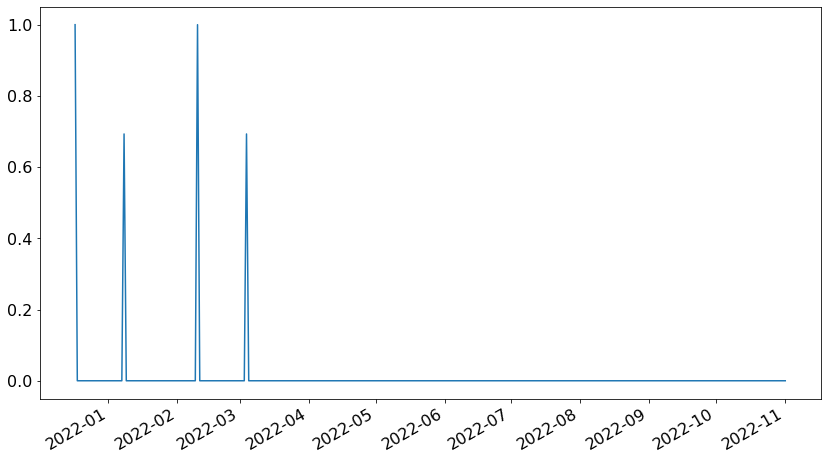

In [107]:
arr = []
for x in lyapunovs:
    if len(x)>0:
        arr.append(max(x))
    else:
        arr.append(0)

DF = pd.DataFrame()
DF['value'] = arr
DF = DF.set_index(pd.to_datetime(df_INR['date']))

plt.plot(DF)
plt.gcf().autofmt_xdate()
plt.show()

# ADF Test

In [108]:
# check for Stationarity - ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_INR['value'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.3001940814468083
p-value: 0.17190538402702799
Critial Values:
   1%, -3.450951662384033
Critial Values:
   5%, -2.8706147570800784
Critial Values:
   10%, -2.571604931640625


In [109]:
"""
From ADF test, it's observed that, data is not stationary. 
We can see p-value is 17% (usually it must be less than 0.05 or 5%), 
and ADF-stat value is greater than all the critical values. 

Both these values confirms the data to be Non-Stationary
"""

"\nFrom ADF test, it's observed that, data is not stationary. \nWe can see p-value is 17% (usually it must be less than 0.05 or 5%), \nand ADF-stat value is greater than all the critical values. \n\nBoth these values confirms the data to be Non-Stationary\n"

# Splitting the dataset

In [110]:
X = df_INR.iloc[:, 2:].values
y = df_INR.iloc[:, 0].values

In [111]:
X.shape

(321, 4)

In [112]:
y.shape

(321,)

In [113]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [114]:
# SMAPE function - Symmetric mean absolute percentage error
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [115]:
# Direction Symmetry - It gives the percentage of occurrences in which the sign of the change in value from one time period to the next is the same for both the actual and predicted time series
def ds(A, F):
    sum_A = 0
    for i in range(1, len(A)):
        sum_A += 1 if (A[i]-A[i-1])*(F[i]-F[i-1])>0 else 0
    return (100*sum_A)/(len(A)-1)

In [128]:
# Theil's U coefficient - The greater accuracy of the forecast, the lower will be the value of the u1
def u1(A,F):
    data = pd.DataFrame({'A_i':A, 'F_i': F})
    data['(A_i - F_i)^2'] = np.square(data['A_i'] - data['F_i'])
    data['F_i^2'] = np.square(data['F_i'])
    data['A_i^2'] = np.square(data['A_i'])
    return (np.sqrt(np.mean(data['(A_i - F_i)^2'])))/(np.sqrt(np.mean(data['F_i^2']))+np.sqrt(np.mean(data['A_i^2'])))

# Linear Regression

In [129]:
# Fitting Linear Regression in dataset
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [130]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.7418405361733843


 SMAPE prediction

In [131]:
print(smape(y_test, y_pred))

1.0389807338320558


 Direction Symmetry prediction

In [132]:
print(ds(y_test, y_pred))

81.25


 Theil's U coefficient prediction

In [133]:
print(u1(y_test, y_pred))

0.00637153165725196


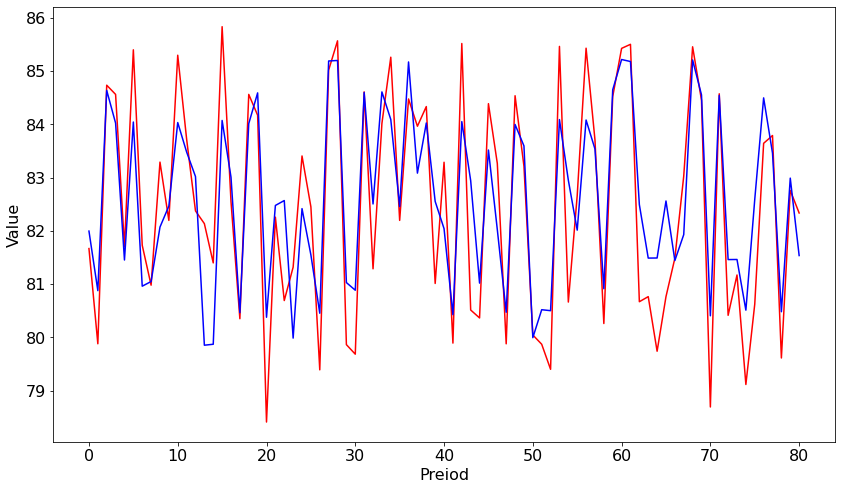

In [134]:
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Polynomial Regression

In [135]:
# Fitting Polynomial Regression in dataset
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_trans, y_train)
y_pred = lr.predict(X_test_trans)

In [136]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.7497895432426632


 SMAPE prediction

In [137]:
print(smape(y_test, y_pred))

1.040735488675978


 Direction Symmetry prediction

In [138]:
print(ds(y_test, y_pred))

83.75


 Theil's U coefficient prediction

In [139]:
print(u1(y_test, y_pred))

0.0062726952798330465


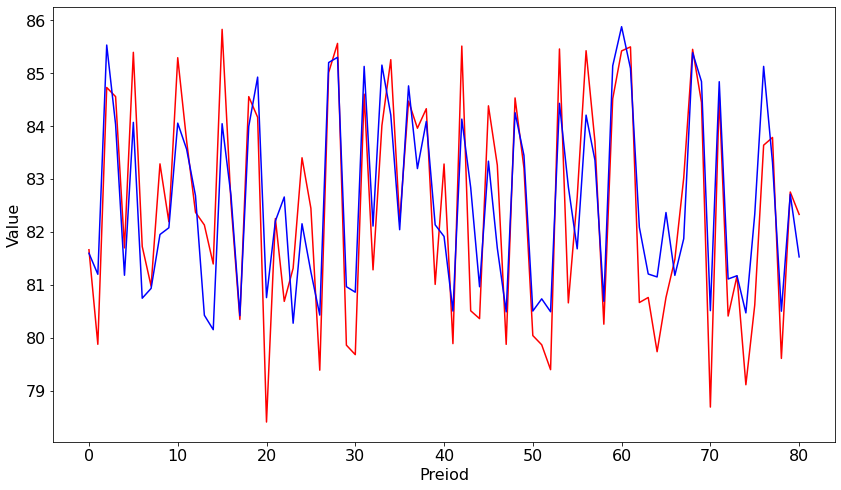

In [140]:
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# LSTM

In [141]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [142]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(LSTM(128))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 256)            267264    
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 464,513
Trainable params: 464,513
Non-trainable params: 0
_________________________________________________________________


In [143]:
# fit model
X_train = np.reshape(X_train, (X_train.shape[0], 1, 4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 4))
history = model.fit(X_train, y_train, epochs=25, batch_size=8, verbose=1, validation_split=0.1)

Epoch 1/25
27/27 [==============================] - 8s 74ms/step - loss: 0.9325 - val_loss: 0.7443
Epoch 2/25
27/27 [==============================] - 0s 10ms/step - loss: 0.5725 - val_loss: 0.2799
Epoch 3/25
27/27 [==============================] - 0s 10ms/step - loss: 0.2646 - val_loss: 0.2478
Epoch 4/25
27/27 [==============================] - 0s 10ms/step - loss: 0.2347 - val_loss: 0.2654
Epoch 5/25
27/27 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.2515
Epoch 6/25
27/27 [==============================] - 0s 10ms/step - loss: 0.2322 - val_loss: 0.2564
Epoch 7/25
27/27 [==============================] - 0s 10ms/step - loss: 0.2252 - val_loss: 0.2622
Epoch 8/25
27/27 [==============================] - 0s 10ms/step - loss: 0.2243 - val_loss: 0.2586
Epoch 9/25
27/27 [==============================] - 0s 10ms/step - loss: 0.2244 - val_loss: 0.2630
Epoch 10/25
27/27 [==============================] - 0s 10ms/step - loss: 0.2208 - val_loss: 0.2527
Epoch 11/

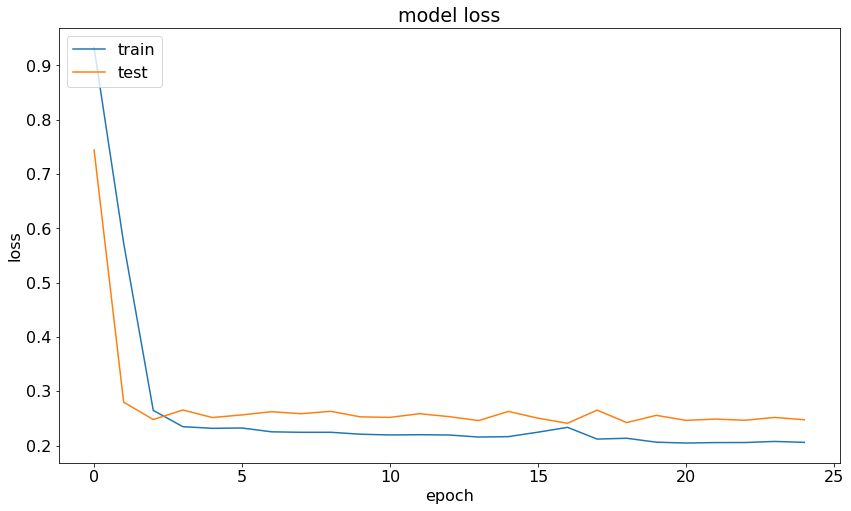

In [144]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [145]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

3/3 [==============================] - 0s 4ms/step
Shape of train and test predict:  (240, 1) (81, 1)


In [146]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict)
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  0.4480521360953176 1.0098293635465854


In [147]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.7497895432426632


 SMAPE prediction

In [148]:
print(smape(y_test, y_pred))

1.040735488675978


 Direction Symmetry prediction

In [149]:
print(ds(y_test, y_pred))

83.75


 Theil's U coefficient prediction

In [150]:
print(u1(y_test, y_pred))

0.0062726952798330465


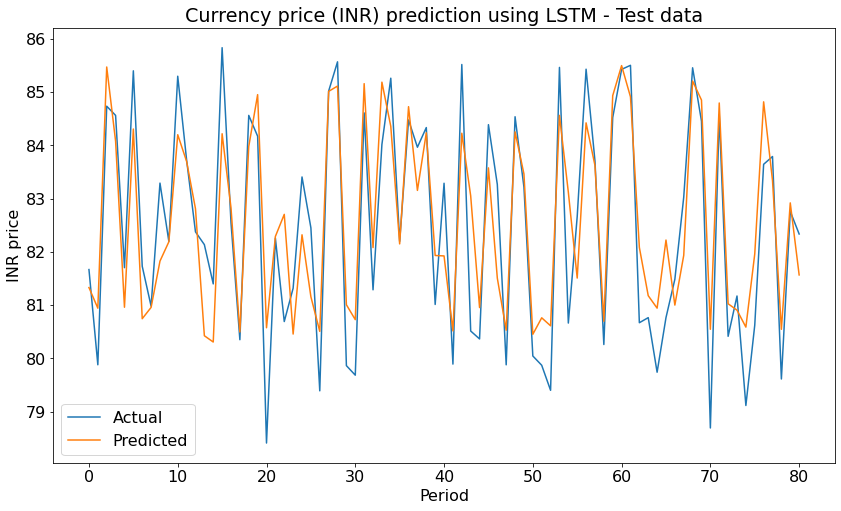

In [151]:
plt.rc("figure", figsize=(14, 8))
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()